In [32]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [33]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# df = df.astype({'y':'int'})
df.asfreq('d')
df = df.set_index('ds')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
ds,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [34]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['ds'])['y'].sum()
data = pd.DataFrame(data)
# data = data.asfreq('d')
# data = data.interpolate(method='linear')
# data = data.fillna(0)
# result = seasonal_decompose(data['y'], model = 'additive')
# result.plot()

In [35]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
ds                     
2021-10-17  375372000.0
2021-10-24  287017000.0
2021-12-08  189834100.0
2022-01-12  262409500.0
2022-01-13  177271000.0
2022-01-16  184863000.0
2022-01-31  204342000.0
2022-02-16  182886300.0
2022-02-17  220170000.0
2022-02-28  213469000.0
2022-07-28  204959459.0
2022-09-17  192559703.0
2022-10-18  184679491.0
2022-11-03  250884985.0
2022-11-06  336473806.0
2022-11-20  326221966.0
2022-12-04  348875662.0
2022-12-07  305095300.0
2022-12-13  236500741.0
2022-12-18  354723498.0
2022-12-23  291265309.0
2023-01-02  281983243.0
2023-01-10  186120115.0
2023-01-16  266497112.0
2023-01-27  485893693.0
2023-01-30  313164440.0
2023-02-13  308880309.0
2023-02-27  222864584.0
2023-03-05  253894290.0
2023-03-07  326880253.0
2023-03-21  221348637.0
2023-03-23  225836091.0
Outliers ke- 2 :                        y
ds                     
2021-10-19  151220000.0
2021-11-05  175035000.0
2021-11-11  155209000.0
2021-11-24  154454900.0
2022

,y
ds,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-11-27,16123000.0
2020-11-28,7344400.0
2020-11-29,31336000.0
...,...
2023-03-26,6122998.0
2023-03-28,895757.0
2023-03-29,58286000.0


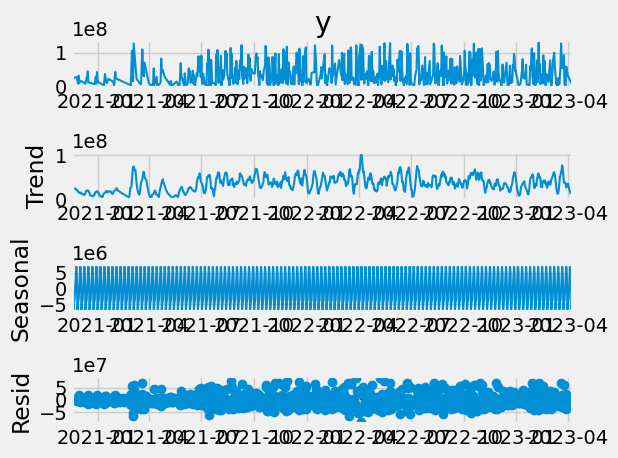

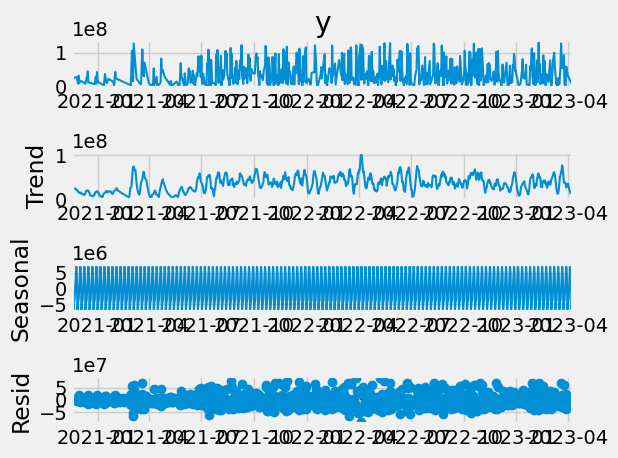

In [36]:
#INTERPOLASI
data = data.asfreq('d')
data = data.interpolate(method='linear')
data = data.fillna(0)
result = seasonal_decompose(data['y'], model = 'additive')
result.plot()

In [38]:
len(data)

873

In [39]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [40]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [41]:
scaled_train[:10]

array([[0.1670466 ],
       [0.17301473],
       [0.17898286],
       [0.18495098],
       [0.19091911],
       [0.19688724],
       [0.20285537],
       [0.2088235 ],
       [0.165918  ],
       [0.12301249]])

In [42]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
#define generator
n_input = 5 #Give prediction based on 5 month
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


In [44]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.1670466  0.17301473 0.17898286 0.18495098 0.19091911]
Predict this y: 
 [[0.19688724]]


In [45]:
X.shape

(1, 5, 1)

In [46]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [48]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [52]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
833/833 [==============================] - 4s 5ms/step - loss: 0.0535
Epoch 2/50
833/833 [==============================] - 4s 5ms/step - loss: 0.0532
Epoch 3/50
833/833 [==============================] - 4s 5ms/step - loss: 0.0531
Epoch 4/50
833/833 [==============================] - 4s 4ms/step - loss: 0.0528
Epoch 5/50
833/833 [==============================] - 4s 5ms/step - loss: 0.0527
Epoch 6/50
833/833 [==============================] - 4s 5ms/step - loss: 0.0524
Epoch 7/50
833/833 [==============================] - 4s 4ms/step - loss: 0.0522
Epoch 8/50
833/833 [==============================] - 4s 4ms/step - loss: 0.0518
Epoch 9/50
833/833 [==============================] - 3s 4ms/step - loss: 0.0519
Epoch 10/50
833/833 [==============================] - 3s 4ms/step - loss: 0.0519
Epoch 11/50
833/833 [==============================] - 3s 4ms/step - loss: 0.0520
Epoch 12/50
833/833 [==============================] - 3s 4ms/step - loss: 0.0517
Epoch 13/50
833/833 [====

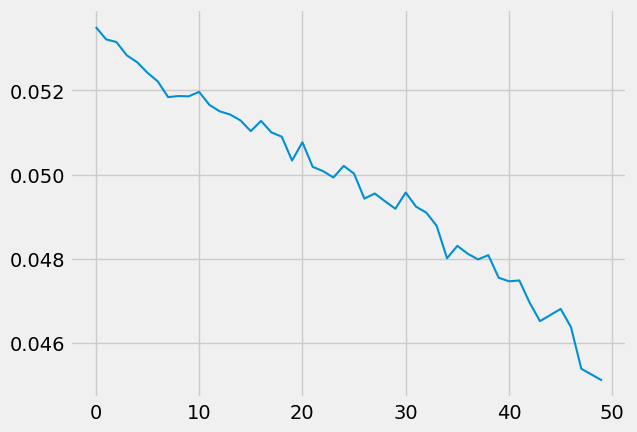

In [53]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [54]:
last_train_batch = scaled_train[-12:]

In [55]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [56]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 178ms/step


array([[0.19751781]], dtype=float32)

In [57]:
scaled_test[0]

array([0.15414737])

In [58]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [59]:
test_predictions

[array([0.19751781], dtype=float32),
 array([0.23193535], dtype=float32),
 array([0.24403653], dtype=float32),
 array([0.23759186], dtype=float32),
 array([0.22567368], dtype=float32),
 array([0.2381922], dtype=float32),
 array([0.29142332], dtype=float32),
 array([0.36864465], dtype=float32),
 array([0.44069928], dtype=float32),
 array([0.541261], dtype=float32),
 array([0.49201357], dtype=float32),
 array([0.37219888], dtype=float32),
 array([0.26414034], dtype=float32),
 array([0.24485846], dtype=float32),
 array([0.25571045], dtype=float32),
 array([0.26479697], dtype=float32),
 array([0.28373516], dtype=float32),
 array([0.31746387], dtype=float32),
 array([0.35567272], dtype=float32),
 array([0.4051563], dtype=float32),
 array([0.44134724], dtype=float32),
 array([0.44068587], dtype=float32),
 array([0.38574272], dtype=float32),
 array([0.33203524], dtype=float32),
 array([0.29617053], dtype=float32),
 array([0.2927941], dtype=float32),
 array([0.3060435], dtype=float32),
 array(

In [60]:
test.head()

,y
ds,
2023-03-13,20201762.0
2023-03-14,628662.0
2023-03-15,23924000.0
2023-03-16,14962000.0
2023-03-17,6000000.0


In [64]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

,y,Predictions
ds,,
2023-03-13,20201762.0,2.588342e+07
2023-03-14,628662.0,3.039222e+07
2023-03-15,23924000.0,3.197751e+07
2023-03-16,14962000.0,3.113324e+07
2023-03-17,6000000.0,2.957192e+07


<Axes: xlabel='ds'>

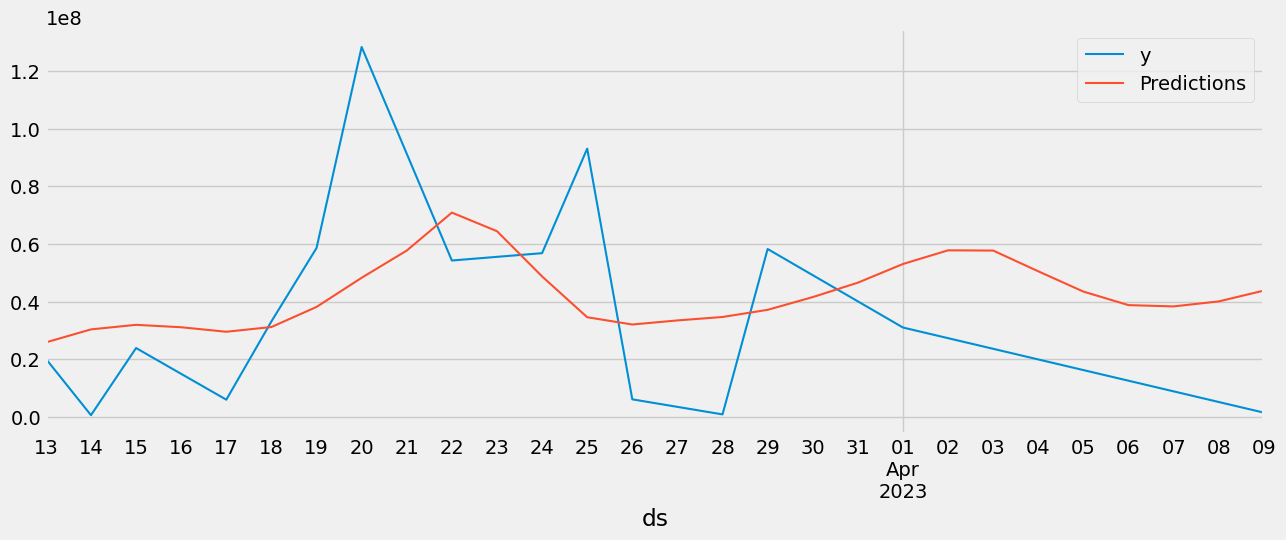

In [69]:
test.plot(figsize=(14,5))

In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 30288331.201942362
Mean Value of Test Dataset: 33628339.28571428
